<a href="https://colab.research.google.com/github/Abrartintoiya018/Genrative_AI_project/blob/main/GAN(generative_Adversarial_Network).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


       0/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1, Gen Loss: 1.6252, Disc Loss: 0.4481
Epoch 2, Gen Loss: 0.8869, Disc Loss: 1.1775
Epoch 3, Gen Loss: 1.0900, Disc Loss: 0.9378
Epoch 4, Gen Loss: 0.9471, Disc Loss: 0.9945
Epoch 5, Gen Loss: 0.9342, Disc Loss: 1.1522
Epoch 6, Gen Loss: 0.9160, Disc Loss: 1.1327
Epoch 7, Gen Loss: 1.1943, Disc Loss: 1.0619
Epoch 8, Gen Loss: 1.1291, Disc Loss: 0.9746
Epoch 9, Gen Loss: 1.0443, Disc Loss: 1.2347
Epoch 10, Gen Loss: 1.2791, Disc Loss: 0.8051


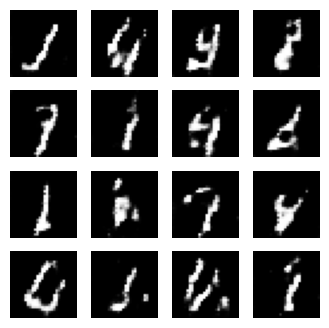

In [2]:
# Load and preprocess MNIST dataset
def load_data():
    (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
    return tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128).prefetch(tf.data.AUTOTUNE)

def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def get_optimizers():
    return tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.Adam(1e-4)

generator = build_generator()
discriminator = build_discriminator()
g_opt, d_opt = get_optimizers()
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Discriminator wants real images as 1, fake images as 0
# Generator wants fake images to be classified as real (1)

@tf.function  # Compiles to a TensorFlow graph for speed
def train_step(images):
    noise = tf.random.normal([128, 100]) # creates a batch of 128 random noise vectors, each of size 100-dimensional

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) # generator takes the random noise as input and produces fake images resembling real MNIST digits
        real_output = discriminator(images, training=True) # discriminator predicts whether real MNIST images are real (should be close to 1)
        fake_output = discriminator(generated_images, training=True) # discriminator predicts whether the generated (fake) images are real (should be close to 0)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output) # tf.ones_like(fake_output) creates a tensor of ones, representing "real" labels
                                                                   # loss_fn (Binary Crossentropy loss) measures how close fake_output is to 1
                                                                   # lower generator loss means the generator is successfully fooling the discriminator
                                                                   # higher generator loss means the generator is performing poorly
        disc_loss = (loss_fn(tf.ones_like(real_output), real_output) + # how well the discriminator classifies real images as real (close to 1)
                     loss_fn(tf.zeros_like(fake_output), fake_output)) # how well the discriminator classifies fake images as fake (close to 0)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # compute gradients for generator parameters
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # compute gradients for discriminator parameters

    g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # update the generator's weights
    d_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # updates the discriminator's weight

    return gen_loss, disc_loss

def train(dataset, epochs=20):
    for epoch in range(epochs):
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")

def generate_and_show():
    noise = tf.random.normal([16, 100])
    images = generator(noise, training=False)
    images = (images + 1) / 2  # Rescale to [0,1]
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, 0], cmap='gray')
        ax.axis('off')
    plt.show()

# Load data and train
mnist_data = load_data()
train(mnist_data, epochs=10)
generate_and_show()


**The @tf.function decorator compiles the function into a TensorFlow computational graph. This makes execution significantly faster because:

TensorFlow optimizes the operations for GPUs.
It avoids Python overhead by compiling it into low-level operations.
It allows parallel execution where possible.
This is beneficial because training deep learning models is computationally intensive, and performance improvements matter.

Early Training: The generator is weak, so fake_output is low. gen_loss is high (because G is failing). The discriminator is strong, so disc_loss is low.

Mid Training: The generator improves, so fake_output increases. gen_loss starts decreasing. The discriminator gets confused, so disc_loss increases.

Late Training (Ideal Case): The generator is very strong, and fake_output ≈ real_output. The discriminator struggles, so both terms in disc_loss balance out. Both gen_loss and disc_loss settle near equilibrium.

tf.GradientTape() is a TensorFlow tool used for automatic differentiation, it helps compute gradients of operations with respect to variables.

How It Works -

Records operations: tf.GradientTape() keeps track of mathematical operations performed on tensors inside its with block.
Computes gradients: After executing operations, we can call .gradient(loss, variables) to compute gradients of the loss with respect to the model parameters.
Applies gradients: The computed gradients are then used by an optimizer (e.g., Adam) to update the model’s weights.
.shuffle(60000)

Randomly shuffles the dataset with a buffer size of 60000. Ensures that each batch gets a diverse mix of data, which helps with generalization.

.batch(128)

Groups the data into batches of 128 samples each for efficient processing. Instead of processing one sample at a time, the model processes 128 samples together.

.prefetch(tf.data.AUTOTUNE)

Optimizes data loading by prefetching batches in the background while the model is training. tf.data.AUTOTUNE allows TensorFlow to automatically decide the optimal number of batches to prefetch based on system resources.

Discriminator is overpowering the generator (disc loss > 1.2), preventing it from learning effectively**